## Bitcoin price prediction using LSTM model

As a first step, the price predictions will only use temporal price data

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

### Import the data

In [2]:
filename = "BTC-USD.csv"
df = pd.read_csv("data/" + filename)

### Prepare the data

In [4]:
# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1828 non-null   datetime64[ns]
 1   Open       1828 non-null   float64       
 2   High       1828 non-null   float64       
 3   Low        1828 non-null   float64       
 4   Close      1828 non-null   float64       
 5   Adj Close  1828 non-null   float64       
 6   Volume     1828 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 100.1 KB


In [12]:
# Split data into training, validation and test sets
training_data = df[(df['Date'] >= "2019-01-01") & (df['Date'] <= "2022-12-31")]['Adj Close']
validation_data = df[(df['Date'] >= "2023-01-01") & (df['Date'] <= "2023-12-31")]['Adj Close']
test_data = df[(df['Date'] >= "2024-01-01") & (df['Date'] <= "2024-12-31")]['Adj Close']

# Reshape the data
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)
test_set = test_data.values.reshape(-1, 1)

In [13]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)
validation_set_scaled = scaler.transform(validation_set)
test_set_scaled = scaler.transform(test_set)

In [7]:
# Create input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [8]:
X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

### Build and train the model

In [9]:
# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

C:\Users\aidas\anaconda3\envs\conda3v11\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Specify the parameters for the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - loss: 0.0632 - val_loss: 0.0026
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 0.0051 - val_loss: 9.2008e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.0052 - val_loss: 9.1656e-04
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0040 - val_loss: 8.3009e-04
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0042 - val_loss: 8.8574e-04
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 12/100
40/40 ━━━━

### Visualise the loss during training

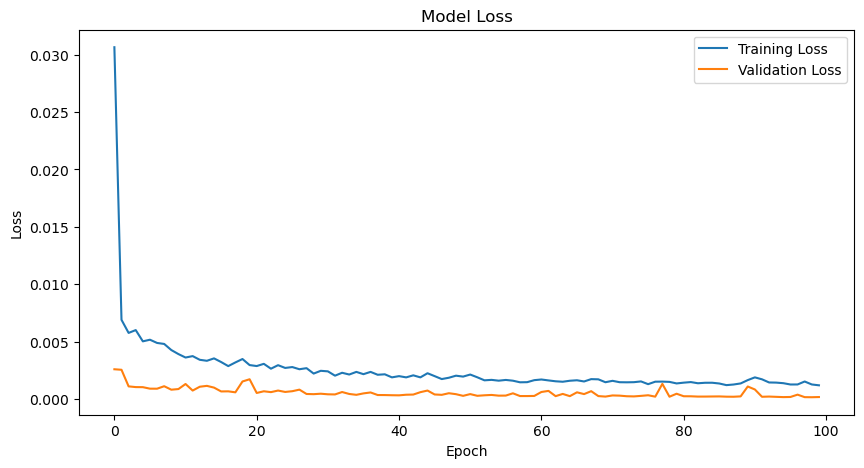

In [11]:
# Plot loss during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test the model on new data

In [28]:
# Create input sequences
X_test, y_test = create_sequences(test_set_scaled)

[[0.62618249]
 [0.63881326]
 [0.60510837]
 [0.62638361]
 [0.62610835]
 [0.62333667]
 [0.62260024]
 [0.67096442]
 [0.65769244]
 [0.66548921]
 [0.66134851]
 [0.60518812]
 [0.60501582]
 [0.58830369]
 [0.59973731]
 [0.61000915]
 [0.60342258]
 [0.57976943]
 [0.58546225]
 [0.58621596]
 [0.58430209]
 [0.55173744]
 [0.55714008]
 [0.56083877]
 [0.55855004]
 [0.58863281]
 [0.59347631]
 [0.592127  ]
 [0.61213869]
 [0.60677674]
 [0.60086576]
 [0.60874434]
 [0.61050302]
 [0.60741002]
 [0.60088136]
 [0.6020809 ]
 [0.6088865 ]
 [0.62859303]
 [0.64430239]
 [0.67378721]
 [0.68375714]
 [0.69210656]
 [0.71869458]
 [0.71524737]
 [0.74854427]
 [0.75033128]
 [0.75387221]
 [0.7459291 ]
 [0.75327063]
 [0.74778463]
 [0.7558639 ]
 [0.74874372]
 [0.74020952]
 [0.73105521]
 [0.74446105]
 [0.74705125]
 [0.79160941]
 [0.83255399]
 [0.91913164]
 [0.89826121]
 [0.91810672]
 [0.91154424]
 [0.92971669]
 [1.01219863]
 [0.93984238]
 [0.97667547]
 [0.98975424]
 [1.01171425]
 [1.01488999]
 [1.02321171]
 [1.07280138]
 [1.06

In [20]:
# Run the model on test data
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [21]:
# Inspect the results
print(predicted_stock_price)

[[59398.51 ]
 [59503.684]
 [59424.625]
 [60283.297]
 [64105.11 ]
 [62589.348]
 [62655.57 ]
 [63665.758]
 [64957.973]
 [65305.777]
 [65501.375]
 [67579.34 ]
 [67734.055]
 [68496.54 ]
 [67632.984]
 [66146.234]
 [63483.023]
 [64866.69 ]
 [65524.684]
 [61936.316]
 [63950.645]
 [64172.117]
 [62653.445]
 [62211.906]
 [64401.984]
 [67095.055]
 [67397.54 ]
 [66642.96 ]
 [67336.76 ]
 [67280.695]
 [67065.94 ]
 [68139.22 ]
 [67388.484]
 [64274.133]
 [63619.926]
 [65593.984]
 [65881.91 ]
 [65986.72 ]
 [66122.95 ]
 [67537.9  ]
 [66263.91 ]
 [66571.56 ]
 [66627.5  ]
 [64793.973]
 [62134.723]
 [62597.695]
 [62017.59 ]
 [61706.984]
 [60098.867]
 [60616.83 ]
 [61427.043]
 [62234.918]
 [62288.957]
 [63311.73 ]
 [63480.76 ]
 [62062.   ]
 [61679.81 ]
 [61499.363]
 [61310.605]
 [61041.08 ]
 [61337.92 ]
 [59570.316]
 [57243.465]
 [56912.426]
 [59555.133]
 [61479.758]
 [61534.36 ]
 [60568.895]
 [59723.082]
 [59002.668]
 [60042.438]]


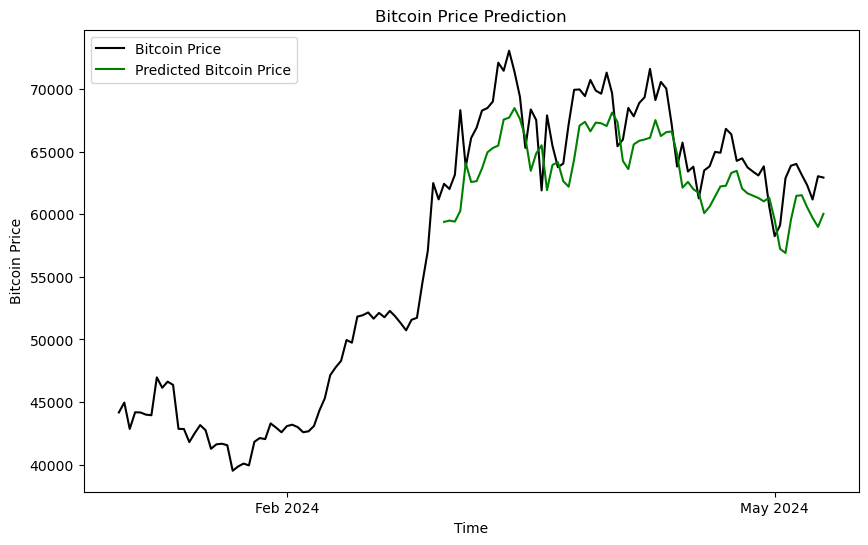

In [29]:
# Visualize the results
date_range = pd.date_range(start='2024-01-01', periods=len(predicted_stock_price), freq='B')
test_dates = df[(df['Date'] >= "2024-01-01") & (df['Date'] <= "2024-12-31")]["Date"]
plt.figure(figsize=(10, 6))
plt.plot(test_dates, test_data, color='black', label='Bitcoin Price')
plt.plot(test_dates[60:], predicted_stock_price, color='green', label='Predicted Bitcoin Price')
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()